# Introduction

In this notebook, we'll be trying to use the original AIRXD-ML labelling code (written in C) to label Martin's data.

Last time we tried this, there was an issue where the 2theta bins that were generated from 'IOtth' were not represented in the 2theta azimuthal map. This caused a segmentation error in the c code since it could not calculate a median for certain 2theta values that were not represented at all.

The purpose of this code is to first double check that all 2theta bins generated are non-empty

In [1]:
import numpy as np
import imageio as iio
import matplotlib.pyplot as plt
import os
from glob import glob

In [2]:
from airxd_cnn.poni_parse import convert_to_imctrl
import airxd
from airxd.mask import MASK

# Defining image size and other metrics for mask

In [3]:
from airxd_cnn.transforms import powder_normalize

In [9]:
#Importing example images from the RC09 dataset

# example_im_dir = 'data/from_martin/Q_MINES_JuneJuly2023_RC09_RawData/'
example_im_dir = 'data/from_martin/Martin_Variable_Sapphire_Spots/'

example_im_files = glob(example_im_dir + '*.Tiff')

example_im = iio.v2.volread(example_im_files[0])
normalized_example_im = powder_normalize(example_im)
example_im.shape

(1043, 981)

Poni to fit2D conversion + MASK instantiation

In [4]:
poni_path = 'data/from_martin/Q_MINES_JuneJuly2023_RC08_RawData/Calibration/LaB6_calibration_225mm_30keV.poni'

controls = convert_to_imctrl(poni_path)

#Post-correction of min and max TA values for IOtth
# controls['IOtth'] = [65.2, 72.8]
# controls['rotation'] = controls['rotation'] + 90

mask = MASK(controls = controls, shape = (1043, 981))

In [6]:
np.min(mask.TA), np.max(mask.TA), controls

(0.031165683642029762,
 30.168989181518555,
 {'distance': 212.76787974570016,
  'center': [84.2757267367562, 89.77996385601888],
  'tilt': 0.5905762636515101,
  'rotation': 161.04262205289908,
  'type': 'Detector',
  'pixelSize': [171.99999999999997, 171.99999999999997],
  'wavelength': 0.41320000000000007,
  'IOtth': [0.8, 17.0],
  'PolaVal': [0.9, False],
  'azmthOff': 0.0,
  'DetDepth': 0.0})

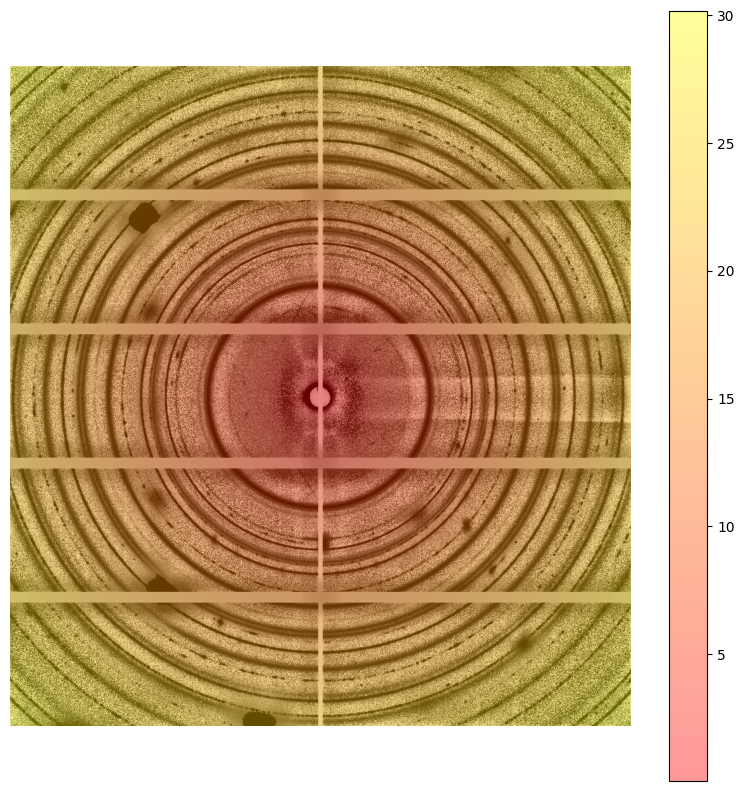

In [10]:
#Overlaying image and mask.TA

plt.figure(figsize=(10,10))
plt.imshow(normalized_example_im, cmap='binary', origin='lower',)  # Base image in grayscale
plt.imshow(mask.TA, cmap='autumn', alpha=0.4)  # Mask overlay with transparency
plt.colorbar()
plt.axis('off')
plt.show()

In [11]:
#Based on this result we'll redo the IOtth to respect these values in the above cell.

np.min(mask.TA), np.max(mask.TA)

(0.031165683642029762, 30.168989181518555)

In [23]:
#We'll be re-creating parts of "AutoSpotMask" without calling the C code. We're simply constructing the 2theta bins and seeing if every bin has some values in it

numchans = 200
LUtth = np.array(controls['IOtth'])
dtth = (LUtth[1]-LUtth[0])/numchans
TThs = np.linspace(LUtth[0], LUtth[1], numchans, False)


In [24]:
#Flatten mask
hist, _ = np.histogram(mask.TA.ravel(), bins = TThs)

In [34]:
lowest_count_indices = np.argsort(hist)[:10]
print(lowest_count_indices, hist[0])


[0 1 2 3 4 5 6 7 8 9] 49


# Troubleshooting 2theta map issues by running through code in mask.py in AIRXD-ML repo

In [3]:
npcosd = lambda x: np.cos(x*np.pi/180.)
npsind = lambda x: np.sin(x*np.pi/180.)
nptand = lambda x: np.tan(x*np.pi/180.)
npatand = lambda x: 180.*np.arctan(x)/np.pi
npatan2d = lambda y,x: 180.*np.arctan2(y,x)/np.pi

In [4]:
def peneCorr(tth, dep, dist):
    return dep*(1.-npcosd(tth))*dist**2/1000.

def makeMat(Angle, Axis):
    '''Make rotation matrix from Angle and Axis
    :param float Angle: in degrees
    :param int Axis: 0 for rotation about x, 1 for about y, etc.
    '''
    cs = npcosd(Angle)
    ss = npsind(Angle)
    M = np.array(([1.,0.,0.],[0.,cs,-ss],[0.,ss,cs]),dtype=np.float32)
    return np.roll(np.roll(M,Axis,axis=0),Axis,axis=1)

def Polarization(Pola, Tth, Azm=0.0):
    """   Calculate angle dependent x-ray polarization correction (not scaled correctly!)

    :param Pola: polarization coefficient e.g 1.0 fully polarized, 0.5 unpolarized
    :param Azm: azimuthal angle e.g. 0.0 in plane of polarization - can be numpy array
    :param Tth: 2-theta scattering angle - can be numpy array
        which (if either) of these is "right"?
    :return: (pola, dpdPola) - both 2-d arrays
        * pola = ((1-Pola)*npcosd(Azm)**2+Pola*npsind(Azm)**2)*npcosd(Tth)**2+ \
        (1-Pola)*npsind(Azm)**2+Pola*npcosd(Azm)**2
        * dpdPola: derivative needed for least squares

    """
    cazm = npcosd(Azm)**2
    sazm = npsind(Azm)**2
    pola = ((1.0-Pola)*cazm+Pola*sazm)*npcosd(Tth)**2+(1.0-Pola)*sazm+Pola*cazm
    dpdPola = -npsind(Tth)**2*(sazm-cazm)
    return pola,dpdPola



In [9]:
def GetTthAzmG2(x, y, data):
    '''Give 2-theta, azimuth & geometric corr. values for detector x,y position;
        calibration info in data - only used in integration - old version
    '''
    'Needs a doc string - checked OK for ellipses & hyperbola'
    #Angle detector normal makes with incident beam (-90 to 90 degrees)
    tilt = data['tilt']
    dist = data['distance']/npcosd(tilt)
    #Rotation matrix product
    #Check makeMat
    MN = -np.inner(makeMat(data['rotation'],2), makeMat(tilt,0))
    
    #Re-center x data based on detector center (from metadata)
    dx = x-data['center'][0]
    #Re-center y data based on detector center (from metadata)
    dy = y-data['center'][1]
    #Steps:
    #1. np.dstack stacks x, y and z coordinates "vertically"
    #2. The dot product applies transformation matrix to all coordinates
    #   We transpose x,y so we can multiply along third dimension in dot product
    
    #dz: z displacement from 0 (assumed planar position originally)
    dz = np.dot(np.dstack([dx.T,dy.T,np.zeros_like(dx.T)]),MN).T[2]

    #Subtraction is because we're going from a "tilted plane" to a "flat plane"
    #Our original tilted plane distance from the origin is dx**2 + dy**2
    #This "OG" tilted plane is actually the "hypotenuse" of the "true" xy distance
    #Hypotenuse = "true xy" + dz **2
    #=> "true xy" = Hypotenuse - dz**2
    xyZ = dx**2+dy**2-dz**2

    #dist = distance from sample to detector plane
    #Azimuthal angle is tth0
    tth0 = npatand(np.sqrt(xyZ)/(dist-dz))

    #Penetration correction for dz
    dzp = peneCorr(tth0, data['DetDepth'], dist)

    #Actual azimuthal correction for every position
    #2theta
    #dist-dz+dzp is corrected distance from sample to pixel
    #xyZ is distance from center of detector to pixel
    #npatan2d takes the sweeping angle from the vector (1,0), horizontal line
    #to the vector ending in (x,y)

    #This view is essentially looking at a cross section of sample and detector
    #2theta angle is deflection angle off of center of detector (no deflection)
    tth = npatan2d(np.sqrt(xyZ),dist-dz+dzp)
    #Azimuthal angle is rotation clockwise from (1,0) to dy/dx value in addition to azimuthal correction
    #Mod 360 in case rotation is greater than 360
    azm = (npatan2d(dy,dx)+data['azmthOff']+720.)%360.
    distsq = data['distance']**2

    #x0 is the displacement of the detector center from the sample center
    x0 = data['distance']*nptand(tilt)
    #x component of x0 correction
    x0x = x0*npcosd(data['rotation'])
    #y component of x0 correction
    x0y = x0*npsind(data['rotation'])

    #Sum of correction distances - geometric correction
    G = ((dx-x0x)**2+(dy-x0y)**2+distsq)/distsq
    return tth,azm,G


In [10]:
def Make2ThetaAzimuthMap(data, iLim, jLim):
    'Needs a doc string'
    pixelSize = data['pixelSize']
    scalex = pixelSize[0]/1000.
    scaley = pixelSize[1]/1000.
    tay,tax = np.mgrid[iLim[0]+0.5:iLim[1]+.5,jLim[0]+.5:jLim[1]+.5]
    tax = np.asfarray(tax*scalex,dtype=np.float32).flatten()
    tay = np.asfarray(tay*scaley,dtype=np.float32).flatten()
    print(tay)
    nI = iLim[1]-iLim[0]
    nJ = jLim[1]-jLim[0]
    TA = np.empty((4,nI,nJ))
    TA[:3] = np.array(GetTthAzmG2(np.reshape(tax,(nI,nJ)),np.reshape(tay,(nI,nJ)),data))
    TA[1] = np.where(TA[1]<0,TA[1]+360,TA[1])
    TA[3] = Polarization(data['PolaVal'][0],TA[0],TA[1]-90.)[0]
    return TA

In [6]:
poni_path = 'data/from_martin/Q_MINES_JuneJuly2023_RC08_RawData/Calibration/LaB6_calibration_225mm_30keV.poni'
controls = convert_to_imctrl(poni_path)
#Flip controls['center'] list from left to right to right to left
# controls['center'] = controls['center'][::-1]
shape = (1043, 981)

In [7]:
controls['center']

[84.2757267367562, 89.77996385601888]

In [11]:
res = Make2ThetaAzimuthMap(controls,(0,shape[0]),(0,shape[1]))

np.min(res[0]), np.max(res[0])

[8.6000e-02 8.6000e-02 8.6000e-02 ... 1.7931e+02 1.7931e+02 1.7931e+02]


(0.031165683642029762, 30.168989181518555)

Comparing ctrl file to known control file

In [216]:
from airxd_cnn.dataset import parse_imctrl

In [217]:
imctrl_file = 'data/battery1/TianyiBatteryControl.imctrl'
known_controls = parse_imctrl(imctrl_file)

In [219]:
known_res = Make2ThetaAzimuthMap(known_controls,(0,2880),(0,2880))
np.min(known_res[0]), np.max(known_res[0])

[7.50000e-02 7.50000e-02 7.50000e-02 ... 4.31925e+02 4.31925e+02
 4.31925e+02]


(0.012266278266906738, 37.817970275878906)

# Checking mask

We seemingly had no issues running the code on his masks. Let's check the result.

We'll run the pipeline on one or two test images just to make sure the general tuning is correct, before using the same parameters on the whole dataset.

In [4]:
from airxd_cnn.transforms import powder_normalize
import importlib


In [5]:
poni_path = 'data/from_martin/Q_MINES_JuneJuly2023_RC08_RawData/Calibration/LaB6_calibration_225mm_30keV.poni'

controls = convert_to_imctrl(poni_path)

#Post-correction of min and max TA values for IOtth
# controls['IOtth'] = [65.2, 72.8]
# controls['rotation'] = controls['rotation'] + 90

mask = MASK(controls = controls, shape = (1043, 981))

In [6]:
#Test image
# example_im_dir = 'data/from_martin/Q_MINES_JuneJuly2023_RC09_RawData/'
example_im_dir = 'data/from_martin/Martin_Variable_Sapphire_Spots/'
example_im_files = glob(example_im_dir + '*.Tiff')
example_im_files.sort()


In [29]:
idx = 7
im = iio.v2.volread(example_im_files[idx])
#Note to future self. Do NOT normalize the images before using median finder or else it simply won't work.
normalized_im = powder_normalize(im)

#Median filter
#Resetting the theta range to max instead of default ([0.8 17] approx)
controls['IOtth'] = [0.032, 30.15]
mask = MASK(controls, shape= im.shape)

im_to_mask = im
esdmul_mask = 1.5
# im_to_mask = normalized_im * 1e5
# esdmul_mask = 0.3

result = mask.AutoSpotMask(im_to_mask, esdmul_mask, numchans=200)


Tam length: 1023183
TA length: 1023183
Band length: 1023183
TThs length: 200
Starting up C code
esdmul: 1.5


<Figure size 1000x1000 with 0 Axes>

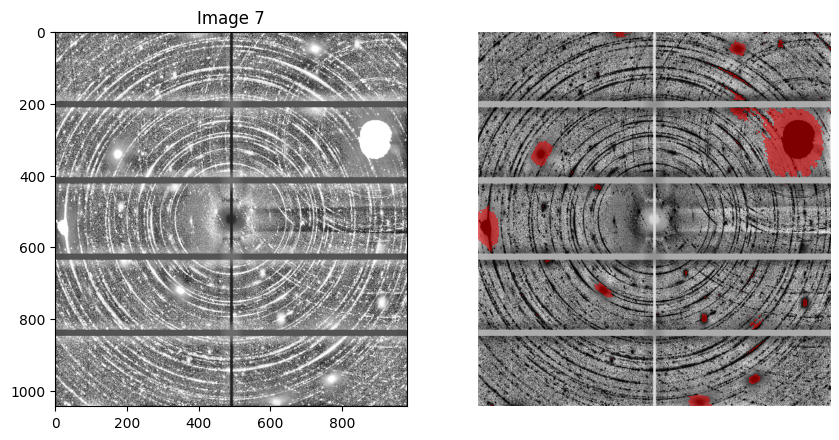

In [30]:
#Plot image with overlay
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(1, 2, figsize=(10,10))

ax[0].imshow(normalized_im, cmap = 'gray')
ax[0].set_title(f'Image {idx}')
ax[1].imshow(normalized_im, cmap='binary', origin='lower',)  # Base image in grayscale
ax[1].imshow(np.ma.masked_where(result == 0, result), cmap='autumn', alpha=0.5)  # Mask overlay with transparency
# ax[1].imshow(result, cmap='autumn')  # Mask overlay with transparency
# plt.colorbar()
plt.axis('off')
plt.show()

# Gaussian convolutions

Note from 01/08/2025

Gaussian convolution is smearing out small islands of labelled noise which doesn't help the final image. May need to do an additional island masking step.

In [9]:
from scipy import ndimage
from scipy.ndimage import label
from skimage.measure import regionprops

In [40]:
def filter_connected_components_by_size(mask, min_size, max_size=None):
    """
    Filters connected components in the mask based on size.
    
    Parameters:
        mask (ndarray): Binary mask where spots are marked as 1, and the background is 0.
        min_size (int): Minimum number of pixels for a connected component to be kept.
        max_size (int, optional): Maximum number of pixels for a connected component to be kept. If None, no upper limit.
        
    Returns:
        filtered_mask (ndarray): Mask with only the connected components that meet the size criteria.
    """
    # Label each connected component in the binary mask
    labeled_mask, _ = label(mask)
    
    # Initialize an empty mask to hold the filtered components
    filtered_mask = np.zeros_like(mask)
    
    # Get properties of labeled regions
    regions = regionprops(labeled_mask)
    
    for region in regions:
        # Check the size of each region
        region_size = region.area
        if region_size >= min_size and (max_size is None or region_size <= max_size):
            # Add this region to the filtered mask
            filtered_mask[labeled_mask == region.label] = 1
    
    return filtered_mask

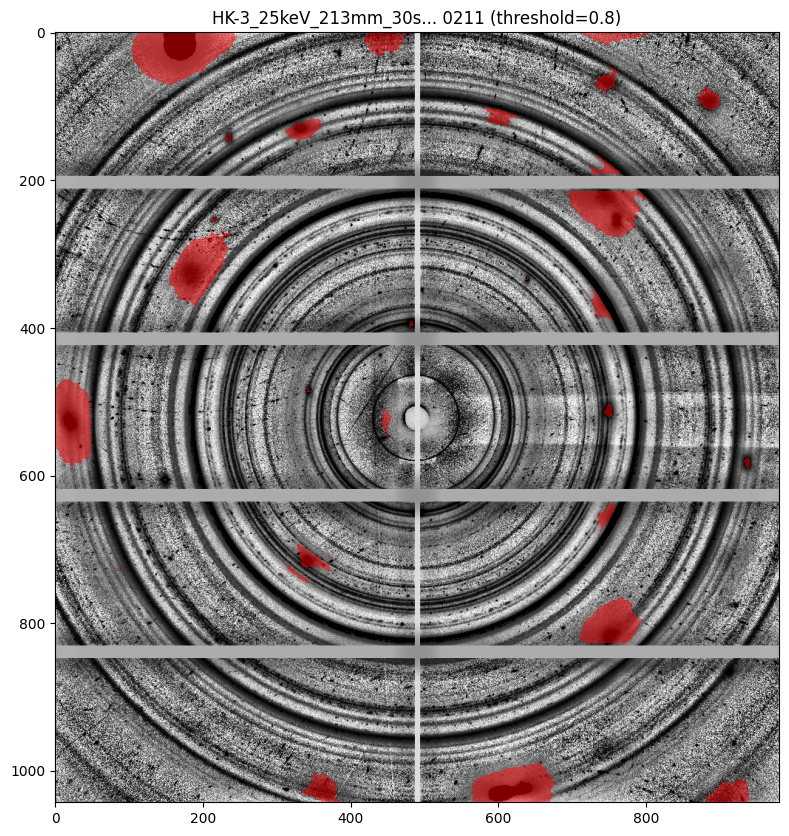

In [28]:
sigma = 2.5  # Adjust this value for different smoothing levels
threshold = 0.8
# Apply island masking first
# island_mask = filter_connected_components_by_size(result, min_size = 2)
smoothed_mask = ndimage.gaussian_filter(result, sigma=sigma)

thresholded_mask = (smoothed_mask > threshold).astype(float)

#Get last portion of file name from example_im_files[idx] separated by '/'
file_suffix = example_im_files[idx].split('/')[-1][:20] + '...' + example_im_files[idx].split('/')[-1][-10:-5]

# Visualize result
plt.figure(figsize=(10,10))
plt.imshow(normalized_im, cmap='binary', origin='lower',)
plt.imshow(np.ma.masked_where(thresholded_mask == 0, thresholded_mask), cmap='autumn', alpha=0.5)
# plt.imshow(smoothed_mask, cmap='autumn')
plt.title(f'{file_suffix} (threshold={threshold})')
# plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Adjusted Image with artifacts removed')

<Figure size 1000x1000 with 0 Axes>

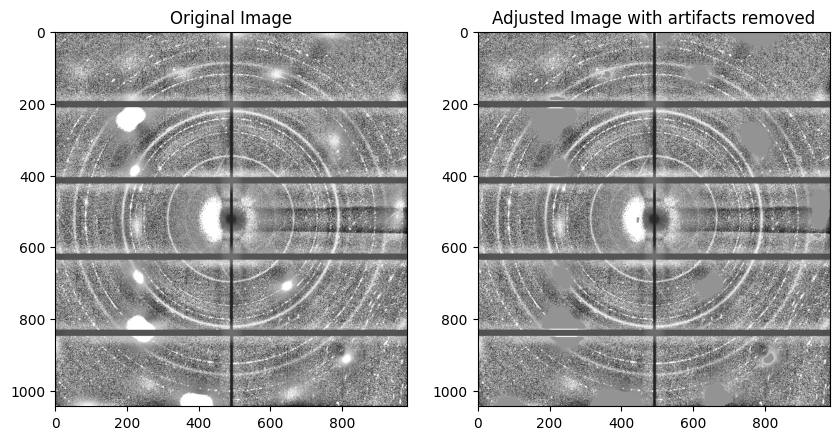

In [67]:
#Replace all the positive mask values with the median of im

med_im = np.median(normalized_im)
adjusted_im = normalized_im.copy()
adjusted_im[thresholded_mask == 1] = med_im



plt.figure(figsize=(10,10))
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(normalized_im, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(adjusted_im, cmap='gray')
ax[1].set_title('Adjusted Image with artifacts removed')


# Pipeline to convert all other images    

In [11]:
import numpy as np
import imageio as iio
import matplotlib.pyplot as plt
import os
from glob import glob
from airxd_cnn.poni_parse import convert_to_imctrl
import airxd
from airxd.mask import MASK
from scipy import ndimage

In [104]:
#Controls pathing
control_path = 'data/from_martin/Q_MINES_JuneJuly2023_RC08_RawData/Calibration/LaB6_calibration_225mm_30keV.poni'
controls = convert_to_imctrl(control_path)
controls['IOtth'] = [0.032, 30.15]

#Median filter parameters
numChans = 200

#Convolution parameters
sigma = 2.5  # Adjust this value for different smoothing levels
threshold = 0.78

In [105]:
base_dir = 'data/from_martin'

sub_dir = glob(base_dir + '/*')

for dir in sub_dir:
    im_list = glob(dir + '/*.Tiff')

    for im_path in im_list:
        print(im_path)
        im = iio.v2.volread(im_path)
        im = powder_normalize(im)

        #Median filter
        mask = MASK(controls, shape= im.shape)
        result = mask.AutoSpotMask(im, esdmul = 0.3, numchans=numChans)

        #Convolution masking
        smoothed_mask = ndimage.gaussian_filter(result, sigma=sigma)
        thresholded_mask = (smoothed_mask > threshold).astype(float)

        #Get save path
        im_name = im_path.split('/')[-1]
        im_name = im_name.replace('.Tiff', '')
        save_path = os.path.join(dir, 'masks', im_name)

        #Save the result
        np.save(save_path, thresholded_mask)

data/from_martin/Q_MINES_JuneJuly2023_RC08_RawData/RC08_FLiNaK_30keV_225mm_6-460_rt_15s  0005.Tiff
Tam length: 1023183
TA length: 1023183
Band length: 1023183
TThs length: 200
Starting up C code
data/from_martin/Q_MINES_JuneJuly2023_RC08_RawData/RC08_FLiNaK_30keV_225mm_6-460_rt_15s  0019.Tiff
Tam length: 1023183
TA length: 1023183
Band length: 1023183
TThs length: 200
Starting up C code
data/from_martin/Q_MINES_JuneJuly2023_RC08_RawData/RC08_FLiNaK_30keV_225mm_6-460_rt_15s  0023.Tiff
Tam length: 1023183
TA length: 1023183
Band length: 1023183
TThs length: 200
Starting up C code
data/from_martin/Q_MINES_JuneJuly2023_RC08_RawData/RC08_FLiNaK_30keV_225mm_6-460_rt_15s  0013.Tiff
Tam length: 1023183
TA length: 1023183
Band length: 1023183
TThs length: 200
Starting up C code
data/from_martin/Q_MINES_JuneJuly2023_RC08_RawData/RC08_FLiNaK_30keV_225mm_6-460_rt_15s  0008.Tiff
Tam length: 1023183
TA length: 1023183
Band length: 1023183
TThs length: 200
Starting up C code
data/from_martin/Q_MINES_

In [85]:
def view_im_and_mask(im_path, mask_path):
    im_name = im_path.split('/')[-1].replace('.Tiff', '')

    #Load image and mask
    im = iio.v2.volread(im_path)
    normalized_im = powder_normalize(im)
    mask = np.load(mask_path)

    # Visualize result
    fig, ax = plt.subplots(1, 2, figsize=(10,10))

    ax[0].imshow(normalized_im, cmap = 'gray')
    ax[0].set_title(f'Image {im_name[:20]}')
    ax[1].imshow(normalized_im, cmap='gray')
    ax[1].imshow(np.ma.masked_where(mask == 0, mask), cmap='autumn', alpha=0.4)
    # plt.colorbar()
    ax[1].set_title(f'Image {im_name[:20]}, threshold={threshold})')
    plt.show()

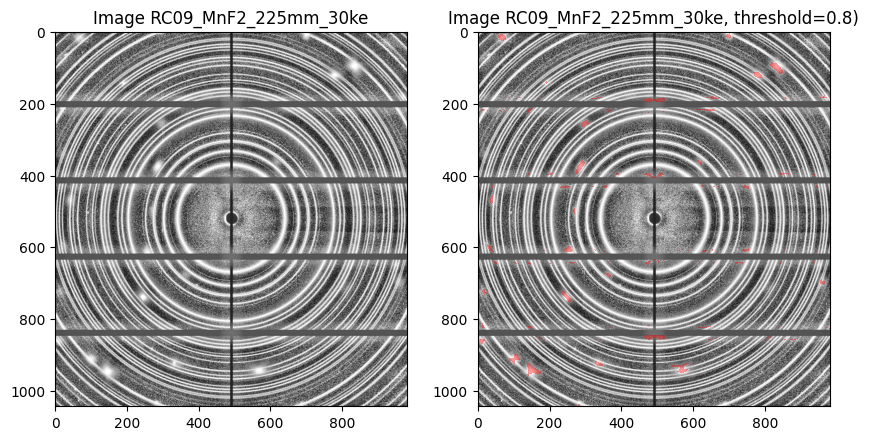

In [86]:
#Image info
sub_index = 1 #Sub directory index
image_index = 11 #Image index within sub directory

#Directory info
base_dir = 'data/from_martin'
sub_dir = glob(base_dir + '/*')
im_list = glob(sub_dir[sub_index] + '/*.Tiff')
im_list.sort()

#Getting paths of mask and image
im_path = im_list[image_index]
im_name = im_path.split('/')[-1].replace('.Tiff', '')
mask_path = os.path.join(sub_dir[sub_index], 'masks', im_name + '.npy')

view_im_and_mask(im_path, mask_path)

